In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In this project, I will be modeling the pickup and tone knob of an electric guitar. The pickup is an application of Faraday's Law, while the tone knob is an alternating current RC circuit, where the power supply is the output of the pickup. This will be broken down into several components, the first of which is to model a single guitar string vibrating over a single coil pickup.
The string will be modeled as a point-like magnetic dipole which has a moment of $1 \text{ Am}^2$. The strength of the dipole is essentially arbitrary, since we only care about the rate of change in flux, which really only depends on the frequency of vibration.

We can model the field around such a dipole using the vector equation below:
$$\vec{B} = \frac{1}{r^3}[3(\vec{\mu} \cdot \hat{r})\hat{r} - \vec{\mu}]$$

This allows us to easily model the vector value of the B field through the coil without having to worry about modeling the dipole as a current loop and having to integrate the Biot-Savart Law

We will start by creating a class to represent the coil with a single oscillating string. Later, we will be able to create an instance of this class for each string in order to model an entire six-string guitar.

The coil itself will be modeled as a square loop of wire, having many loops, but no physical thickness so that we can only worry about the flux through a plane, as opposed to many planes corresponding to many loops.

Before we make the actual class for the pickup, it makes sense to make a helper class to hold all the relevant data for a point in this cross section.

In [4]:
def B(r, mu):
    '''Returns the vector for the B field at a point given r, the direction vector from the dipole,
       and mu, the vector form of the dipole moment'''
    r_mag = np.linalg.norm(r);
    r_hat = r / r_mag
    return 1/r_mag**3 * (3*(np.dot(mu, r_hat)*r_hat) - mu)

In [34]:
class Location:
    '''Contains the position vector and B field vector corresponding to a point in the plane of the coil'''
    def __init__(self, x, y):
        '''Initializes a point given an x and y coordinate (z is always zero)'''
        self.pos = np.array([x, y, 0])
        self.B = np.array([0, 0, 0])
        
    def update_B(self, mu, z):
        '''Calculates the B field vector at a point, given mu, the vector of the dipole moment,
            and z, the z coordinate of the string (we assume it only vibrates in the z dimension)
            Returns the change in the field as a vector'''
        r = np.array([self.pos[0], self.pos[1], -z])
        old = self.B
        self.B = B(r, mu)
        return self.B - old
    
    def update_flux(self, mu, z):
        '''returns the change in flux at given point'''
        return self.update_B(mu, z)[2]

In [53]:
class Pickup:
    '''Essentially houses a 2-D numpy arrays of Location objects and some other information, 
        such as the dimensions of the array, and the rest z coordinate of the string and the number of loops'''
    def __init__(self):
        self.N = 1000
        self.dx = 0.0001
        self.min = -0.005
        self.max = 0.005
        self.npoints = int((self.max - self.min)/self.dx)
        self.x = np.arange(self.min, self.max, self.dx)
        self.y = np.arange(self.min, self.max, self.dx)
        self.z0 = 0.005
        self.dt = 0.0001
        #Forgive me for being bad with numpy arrays, but the ways of C++ are too well engrained in 
        #my head for me to not use loops
        self.plane = np.ndarray(shape = (self.npoints, self.npoints), dtype = Location)
        for (i, j), loc in np.ndenumerate(self.plane):
            x = self.min + i*self.dx
            
            y = self.min + j*self.dx
            
            self.plane[i][j] = Location(x, y)
            
    def get_dflux(self, mu, z):
        '''returns the change in flux through the plane given a dipole moment mu and dipole z coordinate'''
        dflux = 0
        for (i, j), loc in np.ndenumerate(self.plane):
            dflux += self.plane[i][j].update_flux(mu, z)
        return dflux
    
    def induced_emf(self, mu, z, dt):
        '''returns the emf created at a given instantaneous position of the string. Functions called internally
            calculate the change in flux by comparing to the previous value of the B field'''
        return -1*self.N*self.get_dflux(mu,z)/dt
    
    def vibrate(self, vib_func, A, t_max=10):
        '''main driver function that outputs voltage over time given a vibration function and amplitude,
            t is assumed to start at zero and go until t_max, with step self.dt'''
        t_arr = np.arange(0, t_max, self.dt)
        V_arr = np.zeros(np.shape(t_arr))
        mu = np.array([0, 0, -1e-6])
        for i, t in enumerate(t_arr):
            z = vib_func(t, A) + self.z0
            V_arr[i] = self.induced_emf(mu, z, self.dt)
            if i == 0:
                V_arr[i] = 0
        return V_arr

In [40]:
def note_low_E(t, A):
    '''Takes in a time value, t, and an amplitude, A, and returns the displacement from equilibrium
        of a string vibrating at a the A below middle C, or 164.81 Hz. This is the frequency of the bottom
        note of a guitar'''
    f = 164.81
    omega = 2*np.pi*f
    z = A * np.sin(omega*t)
    
    return z

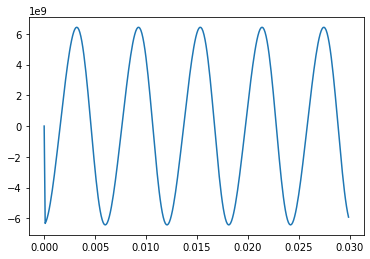

In [54]:
pic1 = Pickup()
t_max = 0.03
t = np.arange(0, t_max, pic1.dt)
V = pic1.vibrate(note_low_E, 0.0005, t_max)
plt.plot(t, V)